In [8]:
#pip install baidu-aip

Note: you may need to restart the kernel to use updated packages.


In [21]:
##write your model id & key here
from aip import AipNlp
APP_ID = ""
API_KEY = ''
SECRET_KEY = '''
cli = AipNlp(APP_ID, API_KEY, SECRET_KEY)

In [ ]:
cli.sentimentClassify(" A股三大股指全线上涨 沪指盘中站上3000大关")#['items'][0]['positive_prob']

In [1]:
#initialize
import pandas as pd
comment_file='D:/股吧评论/gu600519.xlsx'
id='600519'

df = pd.read_excel(comment_file)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

#df['created_time'] = pd.to_datetime(df['created_time'], format='%Y-%m-%d %H:%M:%S')

df['created_time'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M',errors='coerce')
df['created_time'] = df['created_time'].dt.strftime('%Y-%m-%d')
df['polarity'] = 0
df['p'] = 0
#df['title'].apply(lambda x: [w.strip() for w in x.split()])
df = df[df['title']!=0]


#df=df.loc[0:20000,]
df = df[df['title']!=0]# after debug i found there are 127 title which is interge 0, so delete this lines
df=df[10:]


In [ ]:


c=0
import time
import numpy as np
for i in range(60001,100000):
    if i%4 ==0:
        time.sleep(1)
    if i%10000 ==0:
        print(i)
    text = df.iloc[i,5]
    try:
        a = cli.sentimentClassify(text)['items'][0]
        df.iloc[i,9]= a['positive_prob']
        df.iloc[i,8]= a['sentiment']
    except:
        df.iloc[i,9] = 0.5
        df.iloc[i,8] = 1
        c = c+1
        pass

In [24]:
df.iloc[49000]

Unnamed: 0                  49011
author                      剪刀石头包
comment_count                   0
date                  09-29 08:58
read_count                   1222
title                   培育出的民族品牌。
Date             2018-09-29 08:58
created_time           2018-09-29
polarity                        2
p                        0.927902
Name: 49011, dtype: object

In [27]:
df=df[:49000]
start_date='2014-09-01'
def BI_Simple_func(row):
    pos = row[row == 2].count()
    neg = row[row == 0].count()
    neu = row[row == 1].count()
    return (pos-neg)/(pos+neg+neu)
sen_score = df['polarity'].groupby(df.created_time).apply(BI_Simple_func)#.dt.date)


pos_pro = df['p'].groupby(df.created_time).apply(np.mean)

sentiment_idx = pd.concat([sen_score,pos_pro], axis=1)

In [31]:
sentiment_idx=sentiment_idx[1:]

In [35]:
import tushare as ts
ts.set_token('0f4ad972e41d9b89a83e45655560b74c7b37cfb5474dda85440f132e')
pro = ts.pro_api()#need to initialize token first: refer https://tushare.pro/document/1?doc_id=40
if int(id)>100000:
    stock_code=id+'.SH'
else:
    stock_code=id+'.SZ'
quotes = pro.daily(ts_code=stock_code, start_date=start_date)
quotes.set_index('trade_date', inplace=True)
pct_chg=quotes['pct_chg'].shift(periods=1, fill_value=0)
sentiment_idx.index = pd.to_datetime(sentiment_idx.index)
m = pd.merge(sentiment_idx, pct_chg, how='right', left_index=True, right_index=True)
m = pd.merge(m, quotes['close'], how='right', left_index=True, right_index=True)

m = m.dropna(axis=0)


In [37]:
m

,polarity,p,pct_chg,close
trade_date,,,,
2019-02-20,0.000000,0.500000,-0.2424,722.00
2019-02-19,0.000000,0.500000,-1.1988,730.76
2019-02-18,0.000000,0.500000,-1.2486,740.00
2019-02-15,0.000000,0.500000,2.0999,724.78
2019-02-14,0.000000,0.500000,-1.6794,737.16
...,...,...,...,...
2018-10-12,0.032967,0.506096,-0.1647,668.00
2018-10-11,-0.017730,0.481451,3.5675,644.99
2018-10-10,-0.079897,0.466264,-3.8648,670.92


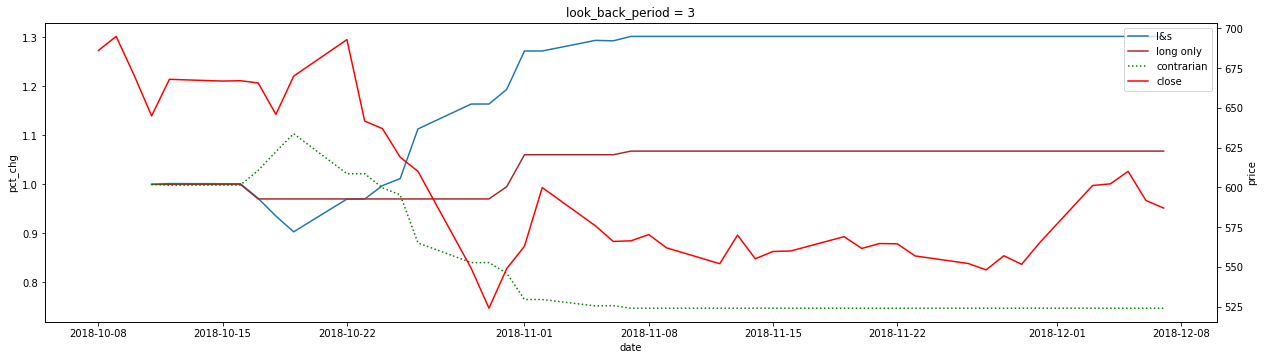

In [46]:
import matplotlib.pyplot as plt
h = m.shape[0]
a= m.iloc[::-1]
l = int(h/2)
m1 = a.iloc[0:l]
m2 = a.iloc[l:]
th_p = np.mean(m1['polarity']) + 0.5 * np.std(m1['polarity'])
th_n = np.mean(m1['polarity']) - 0.5 * np.std(m1['polarity'])

i=3

p3 = np.array(m1['polarity'][0:l-i]>th_p)*(1+m1['pct_chg'][i:l]/100)+np.array(m1['polarity'][0:l-i]<th_p)
p1 = np.array(m1['polarity'][0:l-i]>th_p)*(1+m1['pct_chg'][i:l]/100)+np.array(m1['polarity'][0:l-i]<th_n)*(1-m1['pct_chg'][i:l]/100)+np.array(m1['polarity'][0:l-i]>th_n)*np.array(m1['polarity'][0:l-i]<th_p)
p2 = np.array(m1['polarity'][0:l-i]>th_p)*(1-m1['pct_chg'][i:l]/100)+np.array(m1['polarity'][0:l-i]<th_n)*(1+m1['pct_chg'][i:l]/100)+np.array(m1['polarity'][0:l-i]>th_n)*np.array(m1['polarity'][0:l-i]<th_p)

fig, ax1 = plt.subplots()
fig.set_size_inches(21, 5.5)
ax2 = ax1.twinx()
ax1.plot(np.cumprod(p1), color='#1F77B4',label='l&s')
ax1.plot(np.cumprod(p3), color='brown',label='long only')
ax2.plot(m1['close'],'r',label = 'close')
ax1.plot(np.cumprod(p2), color='g',label='contrarian', linestyle=':')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2 , loc=0)
ax1.set_xlabel('date')
ax1.set_ylabel('pct_chg')
ax2.set_ylabel('price')
title = 'look_back_period = ' + str(i)
plt.title(title)
plt.show()



In [205]:
m2

,polarity,p,pct_chg,close
trade_date,,,,
2018-06-15,0.045455,0.536254,-9.9900,22.82
2018-06-19,-0.103226,0.452383,-9.9800,20.54
2018-06-20,-0.027523,0.483995,-10.0100,18.49
2018-06-21,-0.082262,0.452829,-9.9800,16.64
2018-06-22,0.388889,0.672831,-10.0100,14.98
...,...,...,...,...
2019-02-14,-0.172662,0.410248,0.6565,22.85
2019-02-15,0.040000,0.517245,4.9565,23.00
2019-02-18,0.059633,0.519769,-0.3314,24.14


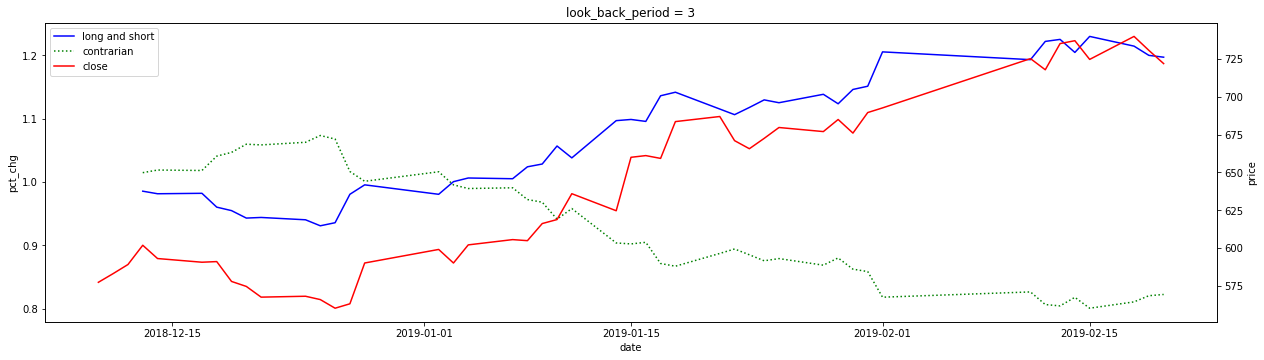

In [53]:
thre_p = np.mean(m['polarity']) + 0.5 * np.std(m2['polarity'])
thre_n = np.mean(m['polarity']) - 0.5 * np.std(m2['polarity'])
l = m2.shape[0]
i=3
#fig, ax1 = plt.subplots()
fig.set_size_inches(21, 5.5)
#long only
p1 = np.array(m2['polarity'][0:l-i]>thre_p)*(1+m2['pct_chg'][i:l]/100)+np.array(m2['polarity'][0:l-i]<thre_p)
#long and short
p2 = np.array(m2['polarity'][0:l-i]>thre_p)*(1+m2['pct_chg'][i:l]/100)+np.array(m2['polarity'][0:l-i]<thre_p)*np.array(m2['polarity'][0:l-i]>thre_n)+np.array(m2['polarity'][0:l-i]<thre_n)*(1-m2['pct_chg'][i:l]/100)
#反转
p3 = np.array(m2['polarity'][0:l-i]>thre_p)*(1-m2['pct_chg'][i:l]/100)+np.array(m2['polarity'][0:l-i]<thre_p)*np.array(m2['polarity'][0:l-i]>thre_n)+np.array(m2['polarity'][0:l-i]<thre_n)*(1+m2['pct_chg'][i:l]/100)

fig, ax1 = plt.subplots()
fig.set_size_inches(21, 5.5)
ax2 = ax1.twinx()
#ax1.plot(np.cumprod(p1), color='brown',label='long only')
ax1.plot(np.cumprod(p2), color='blue',label='long and short')
ax2.plot(m2['close'],'r',label = 'close')
ax1.plot(np.cumprod(p3), color='g',label='contrarian', linestyle=':')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2 , loc=0)
ax1.set_xlabel('date')
ax1.set_ylabel('pct_chg')
ax2.set_ylabel('price')
title = 'look_back_period = ' + str(i)
plt.title(title)
plt.show()


In [50]:
p1

trade_date
2018-12-13    0.985393
2018-12-14    0.995885
2018-12-17    1.000711
2018-12-18    0.977764
2018-12-19    0.994289
2018-12-20    0.987659
2018-12-21    1.001040
2018-12-24    0.996109
2018-12-25    0.989908
2018-12-26    1.005214
2018-12-27    1.047975
2018-12-28    1.015203
2019-01-02    0.985008
2019-01-03    1.020339
2019-01-04    1.005797
2019-01-07    0.998844
2019-01-08    1.018734
2019-01-09    1.004301
2019-01-10    1.027652
2019-01-11    0.982261
2019-01-14    1.056644
2019-01-15    1.001697
2019-01-16    0.997202
2019-01-17    1.036951
2019-01-18    1.004930
2019-01-21    0.976739
2019-01-22    0.992042
2019-01-23    1.010276
2019-01-24    1.010706
2019-01-25    0.996028
2019-01-28    1.011817
2019-01-29    0.986861
2019-01-30    1.020118
2019-01-31    1.004452
2019-02-01    1.047108
2019-02-11    0.989825
2019-02-12    1.024139
2019-02-13    1.002598
2019-02-14    0.983206
2019-02-15    1.020999
2019-02-18    0.987514
2019-02-19    0.988012
2019-02-20    0.997576


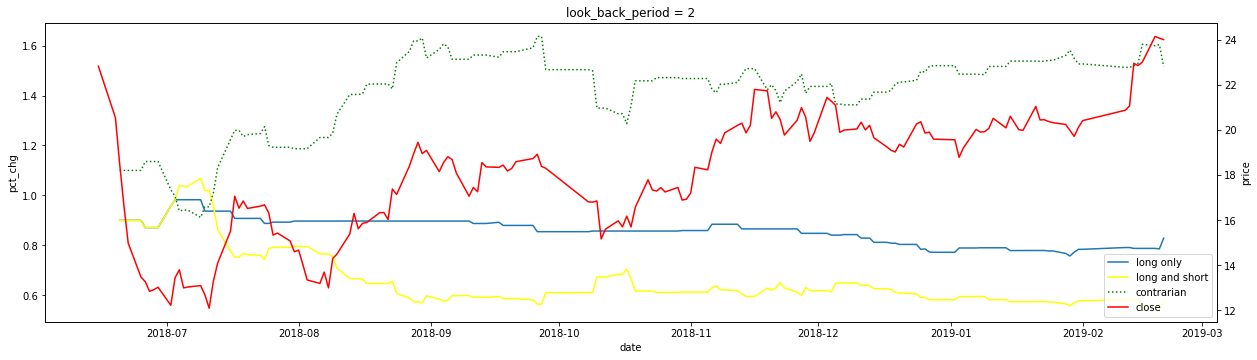

In [208]:
thre_p = np.mean(m['p']) + 0.5 * np.std(m['p'])
thre_n = np.mean(m['p']) - 0.5 * np.std(m['p'])


l = m2.shape[0]
i=2
#fig, ax1 = plt.subplots()
fig.set_size_inches(21, 5.5)
#long only
p1 = np.array(m2['p'][0:l-i]>thre_p)*(1+m2['pct_chg'][i:l]/100)+np.array(m2['p'][0:l-i]<thre_p)
#long and short
p2 = np.array(m2['p'][0:l-i]>thre_p)*(1+m2['pct_chg'][i:l]/100)+np.array(m2['p'][0:l-i]<thre_p)*np.array(m2['p'][0:l-i]>thre_n)+np.array(m2['p'][0:l-i]<thre_n)*(1-m2['pct_chg'][i:l]/100)
#反转
p3 = np.array(m2['p'][0:l-i]>thre_p)*(1-m2['pct_chg'][i:l]/100)+np.array(m2['p'][0:l-i]<thre_p)*np.array(m2['p'][0:l-i]>thre_n)+np.array(m2['p'][0:l-i]<thre_n)*(1+m2['pct_chg'][i:l]/100)

fig, ax1 = plt.subplots()
fig.set_size_inches(21, 5.5)
ax2 = ax1.twinx()
ax1.plot(np.cumprod(p1), color='#1F77B4',label='long only')
ax1.plot(np.cumprod(p2), color='yellow',label='long and short')
ax2.plot(m2['close'],'r',label = 'close')
ax1.plot(np.cumprod(p3), color='g',label='contrarian', linestyle=':')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2 , loc=0)
ax1.set_xlabel('date')
ax1.set_ylabel('pct_chg')
ax2.set_ylabel('price')
title = 'look_back_period = ' + str(i)
plt.title(title)

plt.show()


In [209]:
np.cumprod(1/p1)

trade_date
2018-06-20    1.111235
2018-06-21    1.111235
2018-06-22    1.111235
2018-06-25    1.111235
2018-06-26    1.148444
                ...   
2019-02-14    1.269908
2019-02-15    1.269908
2019-02-18    1.269908
2019-02-19    1.273084
2019-02-20    1.207191
Name: pct_chg, Length: 163, dtype: float64

In [207]:
(1.24**1.5-1)/np.std(1/p1)/np.sqrt(252)

1.5790779339788301

Text(0, 0.5, 'Density')

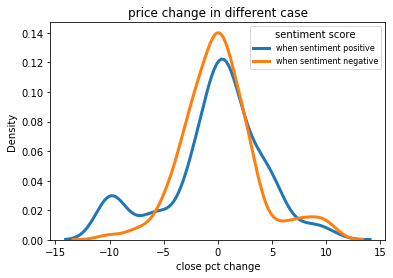

In [210]:
import seaborn as sns
import matplotlib.pyplot as plt
thre_p = np.mean(m['polarity']) + 0.5 * np.std(m['polarity'])
thre_n = np.mean(m['polarity']) - 0.5 * np.std(m['polarity'])
a = m[m['polarity']>thre_p]['pct_chg']
b = m[m['polarity']<thre_n]['pct_chg']
sns.distplot(a, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = 'when sentiment positive')
sns.distplot(b, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = 'when sentiment negative')
plt.legend(prop={'size': 8}, title = 'sentiment score')
plt.title('price change in different case')
plt.xlabel('close pct change')
plt.ylabel('Density')

In [ ]:

a = m[m['p']>thr_p]['pct_chg']
b = m[m['p']<thr_n]['pct_chg']
sns.distplot(a, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = 'when probability large')
sns.distplot(b, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = 'when probability small')
plt.legend(prop={'size': 8}, title = 'sentiment score')
plt.title('price change in different case')
plt.xlabel('close pct change')
plt.ylabel('Density')

In [ ]:

import statsmodels.api as sm
x = np.array(m['polarity'])
X = np.concatenate((x[0:-4],x[1:-3],x[2:-2],x[3:-1])).reshape(105,4,order='F')
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model
y = np.array(m['close'])[3:-1]
# Note the difference in argument order
model = sm.OLS(y, X).fit()
model.summary()

In [ ]:

X = np.concatenate((x[0:-4],x[1:-3],x[2:-2],x[3:-1])).reshape(105,4,order='F')
X.shape